In [276]:
#Expand notebook to take full screen width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

###
import sys
sys.path.insert(0,'../../src/')

%load_ext autoreload
%autoreload 2

#%pdb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [277]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import pickle
import pandas as pd
sns.reset_orig()
matplotlib.rcParams.update({'font.size': 12})

In [278]:
def loadfile(mean, var, zmean, zvar, tau, temp, mixtures, model, data_size = "full",  scaling = False, model_save_dir = "", fn="", file = "res"):
    s = "s" if scaling else "f" 
    exp_name = "{}_m{}_zm{}_r{}_t{}_m{}_kdT{}_{}_{}".format(model, mean, zmean, 50, tau, int(mixtures), int(temp), s, data_size) + fn
    if (file=='res'):
        with open(model_save_dir + '/mnist_retrain_res_{}.p'.format(exp_name),'rb') as f:
            file = pickle.load(f)
    if (file=='gmp'):
        with open(model_save_dir + '/mnist_retrain_gmp_{}.p'.format(exp_name),'rb') as f:
            file = pickle.load(f)
    if (file=='model'):
        file = torch.load(model_save_dir + '/mnist_retrain_model_{}.m'.format(exp_name))
    return file

def stack_weights(weight_dict):
    weights = np.array([], dtype=np.float32)
    for layer in weight_dict:
        weights = np.hstack( (weights, weight_dict[layer] ) )
    return weights

### 1. Accuracy - Loss - Free Parameters

In [279]:
res = loadfile(100, 10, 2500, 1250, 1e-6, int(0), 15, "LeNet_300_100", model_save_dir = "./files")

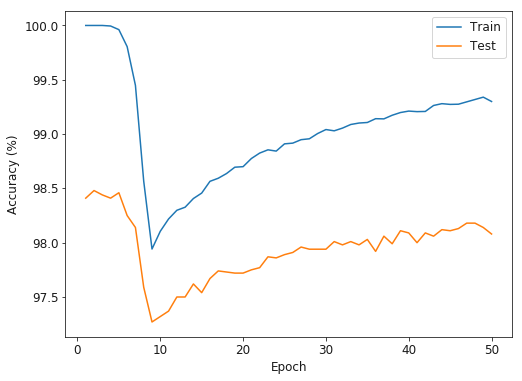

In [280]:
plt.figure(figsize=(8,6))
train = plt.plot(res['epochs'], res['train_acc'], label = "Train")
test = plt.plot(res['epochs'], res['test_acc'], label = "Test")
plt.legend(ncol=1, fontsize=12)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.savefig('figs/swsacc.eps', format='eps', dpi=1000, bbox_inches='tight')
plt.show()

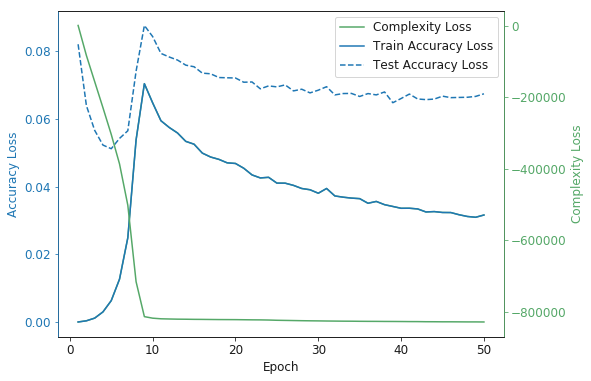

In [281]:
fig, ax1 = plt.subplots(figsize=(8,6))

ax2 = ax1.twinx()
ax1.plot(res['epochs'], res['train_loss'][:-1], label = "Complexity Loss", color = 'g')
p = ax1.plot(res['epochs'], res['train_loss'][:-1], label = "Train Accuracy Loss")
color = p[0].get_color()
ax1.plot(res['epochs'], res['test_loss'], label = "Test Accuracy Loss", linestyle = "--", color = color)
ax1.legend(loc=1)
ax2.plot(res['epochs'], res['complexity_loss'], label = "Complexity", color = 'g')

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy Loss', color=color)
ax2.set_ylabel('Complexity Loss', color='g')
ax2.spines['left'].set_color(color)
ax2.spines['right'].set_color('g')
ax1.tick_params(axis='y', colors=color)
ax2.tick_params(axis='y', colors='g')
plt.savefig('figs/swsloss.eps', format='eps', dpi=1000, bbox_inches='tight')
plt.show()

In [282]:
res = loadfile(100, 1.0, 1000, 1000, 1e-6, int(0), 16, "LeNet_300_100", model_save_dir = "./files")

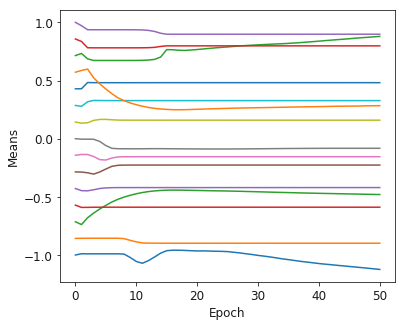

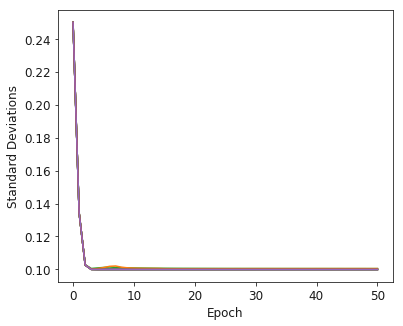

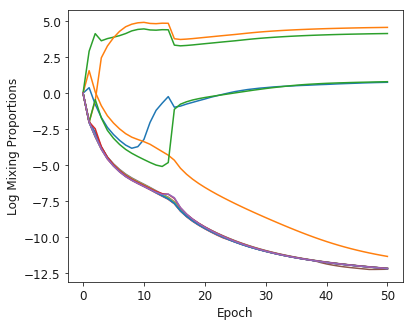

In [283]:
plt.figure(figsize=(6,5))
plt.plot([0] + res['epochs'], res['gmp_means'])
plt.xlabel('Epoch')
plt.ylabel('Means')
plt.savefig('figs/swsmeans.eps', format='eps', dpi=1000, bbox_inches='tight')
plt.show()

plt.figure(figsize=(6,5))
plt.plot([0] + res['epochs'], res['gmp_stddev'][:,1:]) #w/out 0 means
plt.xlabel('Epoch')
plt.ylabel('Standard Deviations')
plt.savefig('figs/swsstd.eps', format='eps', dpi=1000, bbox_inches='tight')
plt.show()

plt.figure(figsize=(6,5))
plt.plot([0] + res['epochs'], np.log(res['gmp_mixprop'][:,:]))
plt.xlabel('Epoch')
plt.ylabel('Log Mixing Proportions')
plt.savefig('figs/swsmixprop.eps', format='eps', dpi=1000, bbox_inches='tight')
plt.show()

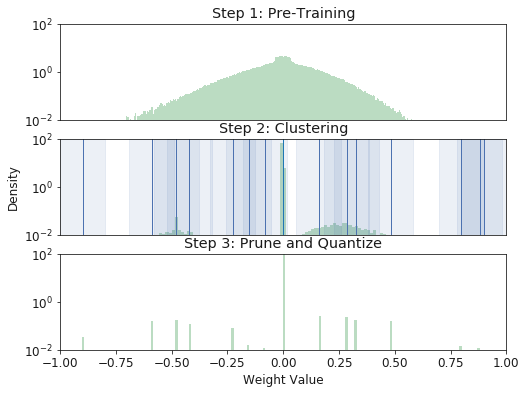

In [284]:
plt.figure(figsize=(8,6))
ax1 = plt.subplot(311)
plt.title("Step 1: Pre-Training")
weights = stack_weights(res['init_weights'])
sns.distplot(weights, kde=False, color="g",bins=400,norm_hist=True, hist_kws={'log':True})
  
plt.xlim([-1, 1])
plt.ylim([1e-2, 1e2])


ax2 = plt.subplot(312)
plt.title("Step 2: Clustering")
plt.ylabel("Density")
weights = stack_weights(res['final_weights'])
sns.distplot(weights, kde=False, color="g",bins=200,norm_hist=True, hist_kws={'log':True})

plt.axvline(0, linewidth = 1)
std_dev0 = res['gmp_stddev'][-1][0]
plt.axvspan(xmin=-std_dev0, xmax=std_dev0, alpha=0.1)
for mean, std_dev in zip(res['gmp_means'][-1], res['gmp_stddev'][-1][1:]):
    plt.axvline(mean, linewidth = 1, color = 'b')
    plt.axvspan(xmin=mean - std_dev, xmax=mean + std_dev, alpha=0.1, color = 'b')
    

plt.xlim([-1, 1])
plt.ylim([1e-2, 1e2])


ax3 = plt.subplot(313)
plt.title("Step 3: Prune and Quantize")
weights = stack_weights(res['prune_weights'])
sns.distplot(weights, kde=False, color="g",bins=200,norm_hist=True, hist_kws={'log':True})

plt.xlabel("Weight Value")
plt.xlim([-1, 1])
plt.ylim([1e-2, 1e2])

plt.setp(ax2.get_xticklabels(), visible=False)
plt.setp(ax1.get_xticklabels(), visible=False)
ax1.xaxis.set_ticks_position('none') 
ax2.xaxis.set_ticks_position('none') 
ax1.set_rasterized(True)
ax2.set_rasterized(True)
ax3.set_rasterized(True)
plt.savefig('figs/swspipeline.eps', format='eps', dpi=500, bbox_inches='tight')
plt.show()



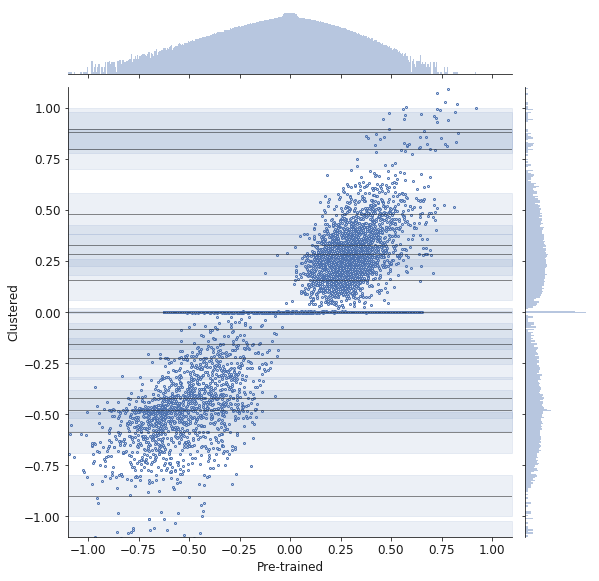

In [285]:
weights_P = stack_weights(res['init_weights'])
weights_C = stack_weights(res['final_weights'])
#weights_P = res['init_weights'][layer]
#weights_C = res['final_weights'][layer]
mu_C = np.concatenate([np.zeros(1), res['gmp_means'][-1]])
std_C = res['gmp_stddev'][-1]
lim = 1.1
#I = np.random.permutation(len(weights_P))
f = sns.jointplot(weights_P, weights_C, size=8, kind="scatter", color="w", stat_func=None, edgecolor='b', marker='o', joint_kws={"s": 4}, marginal_kws=dict(color="b", bins=400), ratio=6)
f.ax_joint.hlines(mu_C, -lim, lim, lw=0.5)

for k in range(len(mu_C)):
    f.ax_joint.fill_between(np.linspace(-lim, lim, 10), mu_C[k] - std_C[k], mu_C[k] + std_C[k], color='b', alpha=0.1)

f.ax_marg_y.set_xscale("log")
f.ax_marg_x.set_yscale("log")
f.set_axis_labels("Pre-trained", "Clustered")

f.ax_marg_x.set_xlim(-lim, lim)
f.ax_marg_y.set_ylim(-lim, lim)
f.ax_marg_x.set_rasterized(True)
f.ax_marg_y.set_rasterized(True)
f.ax_joint.set_rasterized(True)
plt.savefig('figs/swsmap.eps', format='eps', dpi=500, bbox_inches='tight')
plt.show()

### 2. Variance on Gamma Priors

In [286]:
exp = pd.DataFrame(columns = ["var", "zvar", "acc", "sp"])
idx=0
start_processing = False
#start from 10, 1000
for var in [0.1, 1, 10, 100, 1000]:
    for zvar in [0.1, 1, 10, 100, 1000, 10000]:
        fn_text = "_var_{}_zvar_{}".format(var,zvar)
        res = loadfile(100, 10, 2500, 1250, 1e-6, int(0), 15, "LeNet_300_100", model_save_dir = "./files", fn=fn_text)
        exp.loc[idx] = ([var, zvar, res["prune_acc"]["test"], res["sparsity"]])
        idx+=1

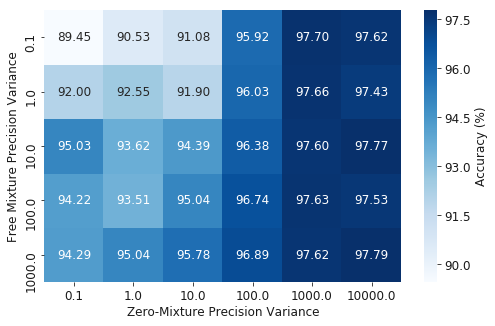

In [287]:
plt.figure(figsize=(8,5))
sns.heatmap(exp.pivot(index='var', columns='zvar', values='acc'), cmap='Blues', cbar_kws = {'label' : 'Accuracy (%)'}, annot=True, fmt=".2f")
plt.xlabel("Zero-Mixture Precision Variance")
plt.ylabel("Free Mixture Precision Variance")
plt.savefig('figs/swsvaracc.eps', format='eps', dpi=1000, bbox_inches='tight')
plt.show()

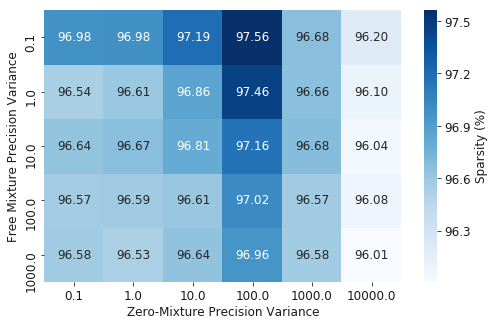

In [288]:
plt.figure(figsize=(8,5))
sns.heatmap(exp.pivot(index='var', columns='zvar', values='sp'), cmap='Blues', cbar_kws = {'label' : 'Sparsity (%)'}, annot=True, fmt=".2f")
plt.xlabel("Zero-Mixture Precision Variance")
plt.ylabel("Free Mixture Precision Variance")
plt.savefig('figs/swsvarsp.eps', format='eps', dpi=1000, bbox_inches='tight')
plt.show()

### 3. Means on Gamma Priors

In [289]:
m_exp = pd.DataFrame(columns = ["mean", "zmean", "acc", "sp"])
idx=0
#start from 10, 1000
for mean in [0.1, 1, 10, 100, 1000]:#, 10000
    for zmean in [0.1, 1, 10, 100, 1000, 10000]:
        res = loadfile(mean, 0.1, zmean, 1000, 1e-6, int(0), 16, "LeNet_300_100", model_save_dir = "./files")
        m_exp.loc[idx] = ([mean, zmean, res["prune_acc"]["test"], res["sparsity"]])
        idx+=1

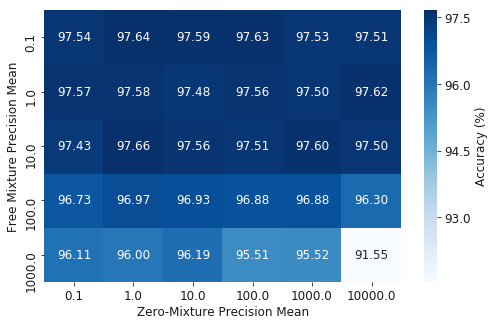

In [290]:
plt.figure(figsize=(8,5))
sns.heatmap(m_exp.pivot(index='mean', columns='zmean', values='acc'), cmap='Blues', cbar_kws = {'label' : 'Accuracy (%)'}, annot=True, fmt=".2f")
plt.xlabel("Zero-Mixture Precision Mean")
plt.ylabel("Free Mixture Precision Mean")
plt.savefig('figs/swsmeanacc.eps', format='eps', dpi=1000, bbox_inches='tight')
plt.show()

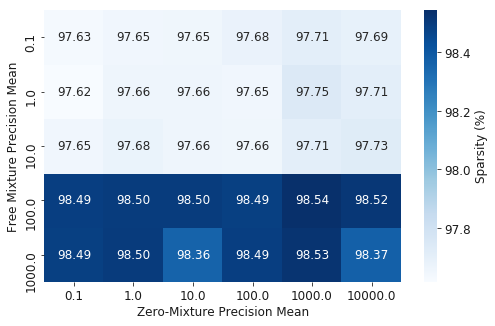

In [291]:
plt.figure(figsize=(8,5))
sns.heatmap(m_exp.pivot(index='mean', columns='zmean', values='sp'), cmap='Blues', cbar_kws = {'label' : 'Sparsity (%)'}, annot=True, fmt=".2f")
plt.xlabel("Zero-Mixture Precision Mean")
plt.ylabel("Free Mixture Precision Mean")
plt.savefig('figs/swsmeansp.eps', format='eps', dpi=1000, bbox_inches='tight')
plt.show()

### 4. Mixtures

In [293]:
mix_exp = pd.DataFrame(columns = ["mixture", "acc", "sp"])
idx=0
#start from 10, 1000
mixlist = [3, 6, 9, 12, 16] # [4 ,5, 7, 8, 10, 11, 13, 14, 15]
for mix in mixlist:
    res = loadfile(1, 0.1, 1000, 1000, 1e-6, int(0), mix, "LeNet_300_100", model_save_dir = "./files")
    mix_exp.loc[idx] = ([mix, res["prune_acc"]["test"], res["sparsity"]])
    idx+=1

In [294]:
mix_exp

,mixture,acc,sp
0,3.0,9.80,98.977533
1,6.0,80.02,97.788155
2,9.0,96.82,97.808409
3,12.0,97.25,97.742395
4,16.0,97.50,97.745771


### 5. Tau

In [296]:
tau_exp = pd.DataFrame(columns = ["tau", "acc", "sp"])
taulist = [1e-5, 2e-5, 1e-6, 5e-6, 2e-6, 5e-7, 2e-7, 1e-7, 5e-8]
for tau in taulist:
    res = loadfile(1, 0.1, 1000, 1000, tau, int(0), 16, "LeNet_300_100", model_save_dir = "./files")
    tau_exp.loc[idx] = ([tau, res["prune_acc"]["test"], res["sparsity"]])
    idx+=1

,tau,acc,sp
5,1.000000e-05,87.05,99.336859
6,2.000000e-05,69.42,99.434380
7,1.000000e-06,97.50,97.745771
8,5.000000e-06,92.57,99.143318
9,2.000000e-06,96.79,98.544316
10,5.000000e-07,97.76,96.647913
11,2.000000e-07,97.73,95.676456
12,1.000000e-07,97.71,95.620569
13,5.000000e-08,97.63,95.463786


### 6. Different Data